# Определяем гиперпараметры

In [33]:
GAUSSIAN_NOISE = 0.1

# downsampling для препроцессинга
IMG_SCALING = (3, 3)
# количество изображений в валидационной выборке
VALID_IMG_COUNT = 900
step_count = 100
MAX_TRAIN_EPOCHS = 30

## Тип модели 
MODEL_TYPE = 'res_unet'

if MODEL_TYPE=='res':
    BATCH_SIZE = 64
else:
    BATCH_SIZE = 48



In [34]:
from keras.applications.resnet50 import ResNet50
from keras.regularizers import l1
from keras.optimizers import Adam, sgd
import os
import numpy as np 
import pandas as pd
from skimage.io import imread, imshow  # читаем иозбражение
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap  ### получить цветовую карту
from skimage.segmentation import mark_boundaries  ### выделение границ
#from skimage.util import montage2d as montage  
from skimage.util.montage import montage2d as montage ## перевод любого размера массива в квадратную матрицу, 
###в нашем случае для того чтобы задать соотношение сторон фотки
from skimage.morphology import binary_opening, disk, label  # бинаризация изображения, 

### для предпоказа картинок
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1) # двигаем 1 измерение 
###на последнее место меняя местами соседов

## Папки с файлами картинок
ship_dir = '../../Data'
#ship_dir = '' ##current
train_image_dir = os.path.join(ship_dir, 'train/')
test_image_dir = os.path.join(ship_dir, 'test/')



############################# Блок функций по работе с масками    #########################################################
def multi_rle_encode(img, **kwargs):
    ##кодируем связанные области в виде раздельных масок. на вхд подаем изображение и получаем RLE формат для областей
    ## с одинаковым цветом. по сути несколько раз подавая на вход кодеру маски из 0 и 1 для каждой уникальной области

    labels = label(img)
    ##labels = img
    if img.ndim > 2:
        ## берем уникальные значения label, передаем в encode матрицу  h x w где каналы схлопнуты по сумме. получается 
        ## двумерный массив из 0 и сумм по каналам
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    Кодируем маску в формат RLE. Навход подаем img 2d из 0 и не 0
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten() ### вытягиваем изображение в одномерный вектор, читая его по строкам. 
    ##Берем первую строчку, первый столбце и вытаскиваем три канала, потом второй столбец
    pixels = np.concatenate([[0], pixels, [0]]) ## добавляем два нуля побокам
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1 ### вычисляем номера пикселей, где есть переход
    # от 0 к 1 - это будет граница
    runs[1::2] -= runs[::2] ## строим маску вычитаем: из номеров пикселей через один их соседей. 
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    Восстанавливаем маску размера shape по RLE
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T 

# ТАк как у нас в файле с масками разные корабли на одном изображении кодируются отдельной строкой,
# То нужна функция объеденяющая несколько масок в одну со всеми кораблями
def masks_as_image(in_mask_list):
    # Объеденим массив масок отдельных кораблей в один. т.е. если у нас для изображения несколько строк с масками
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask) ## битовый  or a = a | b
    return all_masks

def masks_as_color(in_mask_list, sca = 1):
    # создаем массив цветных масок для каждого корабля. Т.е. если несколько масок для картинки, то каждый корабль своим цветом
    # Первая маска будет под цифрой 1, вторая под цифрой 2 и т.д.
    z=768
    z=int(z/sca)
    all_masks = np.zeros((z, z), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2)
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask, shape=(z, z))
    return all_masks

In [35]:
import keras.backend as K

## определяем несколько целевых функций


def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

## Читаем файл с масками, смотрим статистику пустых

In [36]:
masks = pd.read_csv('train_ship_segmentations.csv',encoding= 'utf-8', delimiter=',')
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

56030 masks in 29070 images
75000 empty images in 104070 total images


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
2  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...
3  00021ddc3.jpg  95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4  00021ddc3.jpg  74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...

## Проводим анализ данных

In [5]:
# Посмотрим сколько кораблей у нас есть на каждом изображении, размер файлов с изображениямии
# И отсечем "битые"

ImageId  ships  has_ship has_ship_vec  file_size_kb
14166   2290358c7.jpg      0       0.0        [0.0]     99.055664
55335   87f6db9fd.jpg      4       1.0        [1.0]    116.462891
99725   f542420b6.jpg      0       0.0        [0.0]    115.396484
65751   a1a1a1cd2.jpg      0       0.0        [0.0]    268.452148
5945    0e679f835.jpg      0       0.0        [0.0]    101.767578
49580   79d0e892a.jpg      5       1.0        [1.0]    115.777344
101692  fa2b41c31.jpg      0       0.0        [0.0]    108.646484

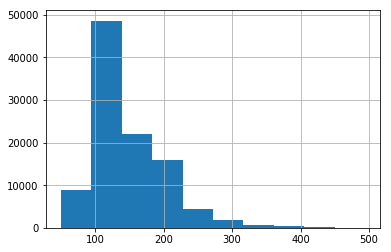

In [37]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
#unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] < 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

### Смотрим как часто встречаются снимки без кораблей

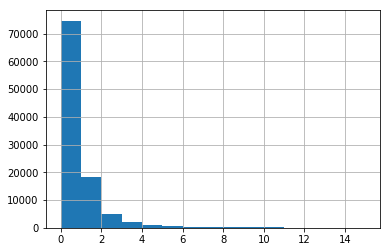

In [38]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

## Undersample "пустых" изображений
Делаем undersample пустых изображений, чтобы получить сбалансированные группы. Так как у нас намного больше изображений без кораблей. Оставляем всего порядка 11000 изображений. Что составляет примерно 10% от всего объема трейна

11256 masks


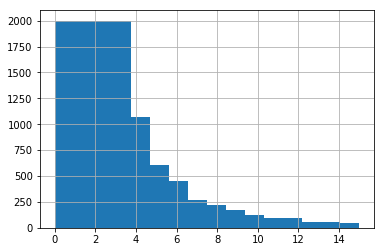

In [39]:
## Группируем по количеству кораблей, если в группе больше 2000 то берем рандомные 2000, если меньше то просто берем все
if MODEL_TYPE == 'res_unet':
    
    SAMPLES_PER_GROUP = 2000
    balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
    balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
    print(balanced_train_df.shape[0], 'masks')
        
if MODEL_TYPE == 'res':
    SAMPLES_PER_GROUP = 8000
    balanced_train_df = unique_img_ids.groupby('has_ship').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
    balanced_train_df['has_ship'].hist(bins=10)
    print(balanced_train_df.shape[0], 'masks')
    

In [9]:
#### Получили 15 групп по количеству изображений в каждой

## Делим на трайн и валид со стратификацией по количеству кораблей на изображениях

In [40]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.3, 
               ##  stratify = balanced_train_df['ships']
                                       )
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

24232 training masks
10561 validation masks


In [41]:
train_df.head()

ImageId                                      EncodedPixels  ships  \
0  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...      9   
1  00021ddc3.jpg  95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...      9   
2  00021ddc3.jpg  74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...      9   
3  00021ddc3.jpg  150423 2 151190 3 151958 3 152726 4 153495 3 1...      9   
4  00021ddc3.jpg  139644 2 140408 6 141174 9 141942 9 142711 6 1...      9   

   has_ship has_ship_vec  file_size_kb  
0       1.0        [1.0]    242.910156  
1       1.0        [1.0]    242.910156  
2       1.0        [1.0]    242.910156  
3       1.0        [1.0]    242.910156  
4       1.0        [1.0]    242.910156

# Переводим все маски в изображения
Создаем под это дело генератор

In [42]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId')) ## получаем список кортежей, где первый элемент - снимок, а второй описание
    out_rgb = []
    out_mask = []
    out_binary_mask = []
    while True:
        np.random.shuffle(all_batches) ## Перемешиваем набор
        for c_img_id, c_masks in all_batches: ##Берем наименование картинки и описание(в нем содержатся и маски)
            rgb_path = os.path.join(train_image_dir, c_img_id) ##Получаем путь картинки в папке
            c_has_ship = c_masks['has_ship'].max()
            c_img = imread(rgb_path) ##Читаем картинку
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)## Передаем в функцию массив масок ,
            # получаем массив 2d из 0 и 1. Добавляем в него 3 измерение. В итоге получаем rgb маску
            if IMG_SCALING is not None: # Ужимаем изображение в n раз
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            out_binary_mask +=[c_has_ship]
            
            if len(out_rgb)>=batch_size: # Когда количество картинок достигает размера бача
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0),np.stack(out_binary_mask,0)  ## Возращаем генератор картинок 
                out_binary_mask, out_rgb, out_mask=[], [], []

In [43]:
train_gen = make_image_gen(train_df) ## создаем генератор
train_x, train_y, train_y_binary = next(train_gen) ## Вызываем его первый раз
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())
print('y_bin', train_y_binary.shape, train_y_binary.min(), train_y_binary.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1
y_bin (48,) 0.0 1.0


In [14]:
###Получаем 4d массив, где первое измерение создержит картинку, а остальные три ее координаты

### Нарисуем, что получилось при создании бача

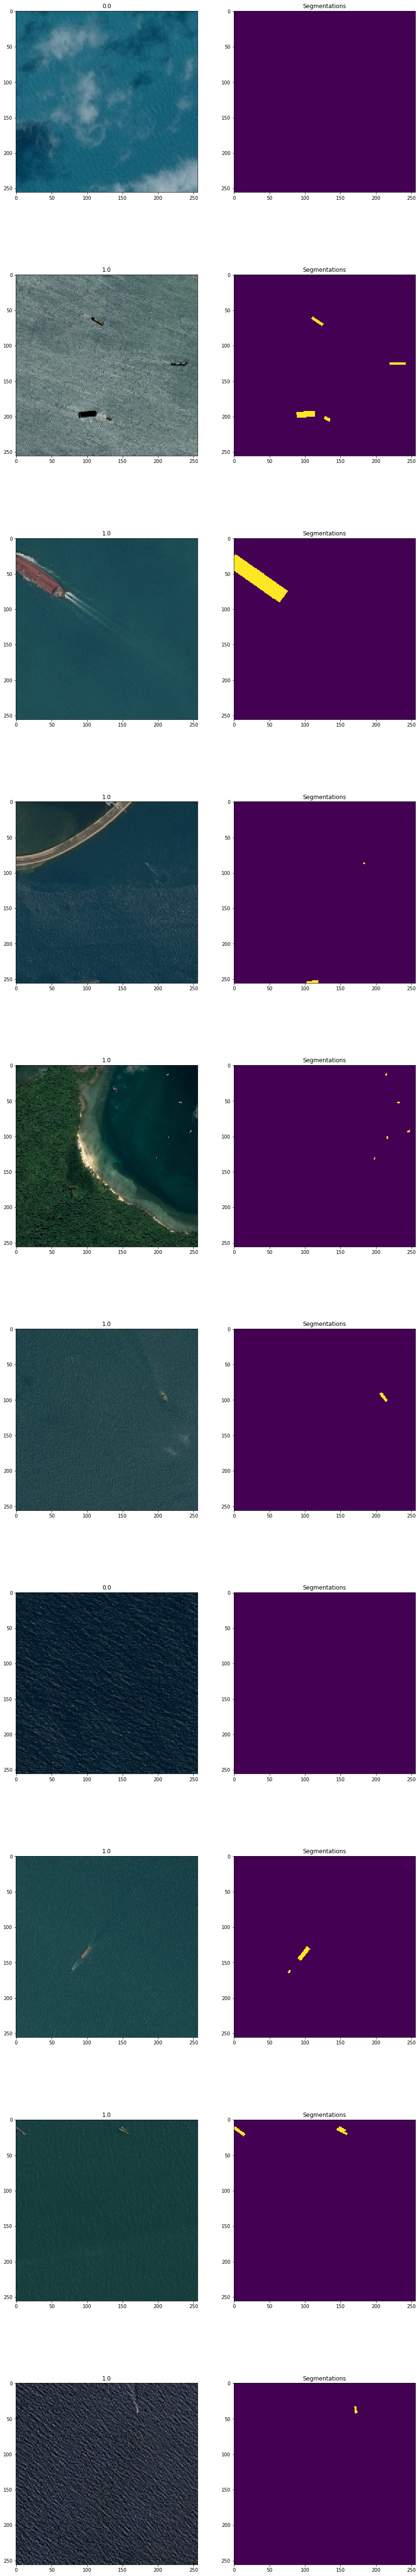

In [44]:
fig, m_axs = plt.subplots(10, 2, figsize = (15, 100))

for (ax1, ax2), x,y,z in zip(m_axs, train_x, train_y, train_y_binary):

    ax1.imshow(x)
    ax1.set_title(''+ str(z))
  
    ax2.imshow(y.reshape(y.shape[0],y.shape[1]))
    ax2.set_title('Segmentations')
    

# Генерим валидационный набор

In [45]:
%%time
valid_x, valid_y, valid_y_bin = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape, valid_y_bin.shape)


(900, 256, 256, 3) (900, 256, 256, 1) (900,)
CPU times: user 12.7 s, sys: 1.36 s, total: 14 s
Wall time: 15.4 s


# Аугументация данных

In [46]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01, 
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, ## Переворачиваем по горизонтали
                  vertical_flip = True, ## Поворачиваем по вертикали
                  fill_mode = 'reflect', ###  как заполнять пустые зоны
                   data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None, mode = 'img+mask'):
    for in_x, in_y, in_y_bin in in_gen:

        seed = np.random.choice(range(9999))

        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        if mode == 'img+mask':
            g_x = image_gen.flow(in_x,
                                 batch_size = in_x.shape[0], 
                                 seed = seed, 
                                 shuffle=True)
        else:
            g_x = image_gen.flow(in_x ,in_y_bin,
                                 batch_size = in_x.shape[0], 
                                 seed = seed, 
                                 shuffle=True)
        
            
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
            
        if mode == 'img+mask':
            return zip(g_x, g_y)
        if mode == 'img+label':
            return g_x
        if mode == 'img+label+mask':
            return zip(g_x, g_y)



## Посмотрим как работает аугументация. Вызываем генератор, смотрим на размеры данных.
### смотрим 9 картинок и масок

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0
y_bin (48,) float64 0.0 1.0


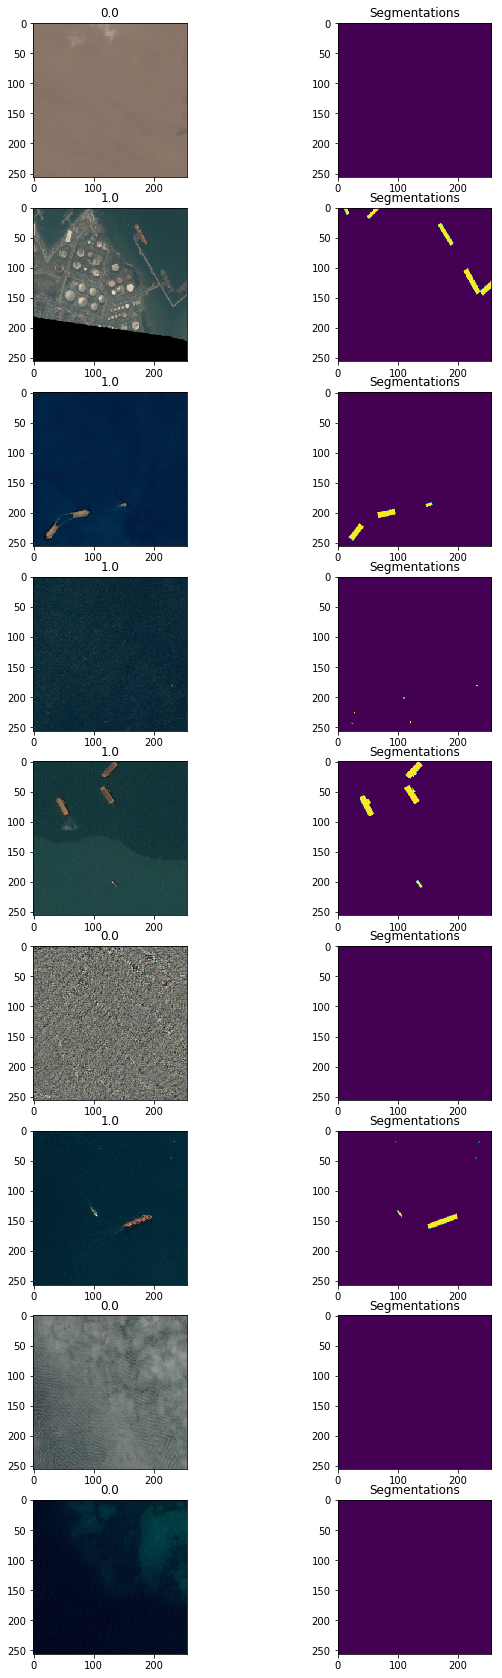

In [47]:
cur_gen = create_aug_gen(make_image_gen(train_df), mode= 'img+label+mask')
t_x_y_bin, t_y = next(cur_gen)

t_x = t_x_y_bin[0]
t_y_bin = t_x_y_bin[1]

print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
print('y_bin', t_y_bin.shape, t_y_bin.dtype, t_y_bin.min(), t_y_bin.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
t_y_bin = t_y_bin[:9]




fig, m_axs = plt.subplots(9, 2, figsize = (10, 30))

for (ax1, ax2), x,y,z in zip(m_axs, t_x, t_y,t_y_bin):

    ax1.imshow(x)
    ax1.set_title(''+ str(z))
  
    ax2.imshow(y.reshape(y.shape[0],y.shape[1]))
    ax2.set_title('Segmentations')
fig.savefig('overview.png')

# Описываем класс с нашими моделями

In [48]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras import layers, models

class Model ():
    def __init__(self, model_type,  data_gen= None,   \
                 max_train_epochs = MAX_TRAIN_EPOCHS , \
                 step_count=step_count, valid_x=valid_x, valid_y = valid_y,\
                 optimizer=None ,loss=None,metrics=None,validation_data= None):
        
        self.model_type = model_type
        self.name = model_type  ##Имя файла с весами
       ## self.data_gen = data_gen
        self.model = None   ## переменная мощдели
        self.max_train_epochs= max_train_epochs
        self.step_count = step_count
        self.valid_x = valid_x
        self.valid_y = valid_y
        self.optimizer = optimizer
        self.loss= loss
        self.metrics = metrics
        self.validation_data = validation_data
        
        
#####################################################################################
        if self.model_type =='res':
            base_model = ResNet50(weights='imagenet', include_top= False, input_shape= t_x.shape[1:],classes=2)

            o = base_model.output
            o = layers.MaxPooling2D(pool_size=(8,8))(o)
            o = layers.Flatten()(o)
            o = layers.Dense(1,  # один выход
                            activation='sigmoid',  # функция активации  
                            kernel_regularizer=l1(1e-4)
                            )(o)

            self.model = models.Model(inputs=[base_model.input], outputs=[o])
            self.model.summary()
      
#####################################################################################
        if self.model_type =='res_unet':
            # Предобученный декодер

            i = ResNet50(weights=None, include_top= False, input_shape= t_x.shape[1:],classes=2)

            o = i.output
            o = layers.AveragePooling2D(pool_size=(8,8))(o)
            o = layers.Flatten()(o)
            o = layers.Dense(1,  # один выход
                            activation='sigmoid',  # функция активации  
                            kernel_regularizer=l1(1e-4)
                            )(o)
            res =  models.Model(inputs=[i.input], outputs=[o])
            weight_path="{}_weights.best.hdf5".format('res')
            res.load_weights (weight_path)

            o = res.layers[-4].output
            o = layers.ZeroPadding2D( (1,1)  )(o)
            o = layers.Conv2D(512, (3, 3), padding='valid',activation = 'relu')(o)
           
            o = layers.UpSampling2D( (2,2))(o)
            o = layers.concatenate([ o ,i.layers[141].output],axis=3)  
            o = layers.ZeroPadding2D( (1,1))(o)
            o = layers.Conv2D( 256, (3, 3), padding='valid',activation = 'relu')(o)
           

            o = layers.UpSampling2D( (2,2))(o)
            o = layers.concatenate([o,i.layers[79].output],axis=3 ) 
            o = layers.ZeroPadding2D((1,1))(o)
            o = layers.Conv2D( 256 , (3, 3), padding='valid' ,activation = 'relu') (o)
            o = layers.BatchNormalization()(o)

            o = layers.UpSampling2D( (2,2))(o)
            o = layers.ZeroPadding2D((1,1)   )(o)
            o = layers.Conv2D( 128 , (3, 3), padding='valid',activation = 'relu' )(o)
            o = layers.BatchNormalization()(o)

            o = layers.UpSampling2D( (2,2))(o)
            o = layers.concatenate([o,i.layers[4].output],axis=3 ) 
            o = layers.ZeroPadding2D((1,1) )(o)
            o = layers.Conv2D( 64 , (3, 3), padding='valid' ,activation = 'relu')(o)
            o = layers.BatchNormalization()(o)
            
            o = layers.UpSampling2D( (2,2))(o)
            o = layers.ZeroPadding2D((1,1) )(o)
            o = layers.Conv2D( 32 , (3, 3), padding='valid' ,activation = 'relu')(o)
            o = layers.BatchNormalization()(o)


            o = layers.Conv2D(1, (1, 1), activation='sigmoid') (o)



            self.model = models.Model(inputs=[i.input], outputs=[o])
            self.model.summary()

        
    def call_back(self):
        weight_path="{}_weights.best.hdf5".format(self.model_type)
        ### Опеределяем callback функции, которые вызвываеются после каждой эпохи 
        ###Сохраняем модель после каждой эпохи, сохраняем только лучшие веса
        checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min', save_weights_only = True)

        reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                           patience=1, 
                                           verbose=1, mode='min', min_delta=0.001, cooldown=2, min_lr=1e-6)
        early = EarlyStopping(monitor="val_loss", 
                              mode="min", 
                              patience=2) # probably needs to be more patient, but kaggle time is limite
        callbacks_list = [checkpoint, early, reduceLROnPlat]
        return callbacks_list
        
        
        ############# Компилируем #####################
    def Compile (self):
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
    ####################### Обучаем###############
    def Fit(self, data_gen):
        
        loss = self.model.fit_generator(data_gen,
                             steps_per_epoch=self.step_count,
                             epochs=self.max_train_epochs,
                             validation_data=self.validation_data,
                             callbacks=self.call_back(),
                             workers=1 
                                       )
        return loss
    
    def Predict (self,x):
        pred=self.model.predict(x)
        return pred

 # ResNet

In [49]:
## Создаем модель
res = Model(model_type = 'res',optimizer= sgd(lr = 5e-5),loss='binary_crossentropy', metrics=['accuracy',true_positive_rate],\
           validation_data = (valid_x,valid_y_bin))

## Компилируем и обучаем
res.Compile()
#loss_history_res = res.Fit(data_gen = create_aug_gen(make_image_gen(train_df),mode = 'img+label'))

## Загружаем лучшие веса и сохраняем
weight_path="{}_weights.best.hdf5".format('res')
res.model.load_weights(weight_path) ## загружаем лучшие веса


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________

In [55]:
loss_history_res = res.Fit(data_gen = create_aug_gen(make_image_gen(train_df),mode = 'img+label'))

Epoch 1/30
 63/100 [=================>............] - ETA: 41s - loss: 0.6788 - acc: 0.8271 - true_positive_rate: 0.8541

KeyboardInterrupt: 

 # ResNet + U-Net

In [50]:
## Создаем модель
res_unet = Model(model_type = 'res_unet',optimizer= Adam(lr = 5e-3),loss=dice_p_bce,\
                 metrics=[dice_coef, 'accuracy', true_positive_rate],validation_data = (valid_x,valid_y))


## Компилируем и обучаем
res_unet.Compile()
##loss_history_res_unet = res_unet.Fit(data_gen = create_aug_gen(make_image_gen(train_df),mode = 'img+mask'))

## Загружаем лучшие веса и сохраняем
weight_path="{}_weights.best.hdf5".format('res_unet')
res_unet.model.load_weights(weight_path) ## загружаем лучшие веса


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [21]:
loss_history_res_unet = res_unet.Fit(data_gen = create_aug_gen(make_image_gen(train_df),mode = 'img+mask'))

Epoch 1/30
100/100 [==============================] - 98s 983ms/step - loss: -0.2920 - dice_coef: 0.2956 - acc: 0.6910 - true_positive_rate: 0.8240 - val_loss: -0.1316 - val_dice_coef: 0.1400 - val_acc: 0.4708 - val_true_positive_rate: 0.6284

Epoch 00001: val_loss improved from inf to -0.13163, saving model to res_unet_weights.best.hdf5
Epoch 2/30
100/100 [==============================] - 79s 787ms/step - loss: -0.4737 - dice_coef: 0.4755 - acc: 0.8714 - true_positive_rate: 0.8061 - val_loss: -0.2196 - val_dice_coef: 0.2230 - val_acc: 0.7777 - val_true_positive_rate: 0.4477

Epoch 00002: val_loss improved from -0.13163 to -0.21964, saving model to res_unet_weights.best.hdf5
Epoch 3/30
100/100 [==============================] - 82s 824ms/step - loss: -0.5568 - dice_coef: 0.5576 - acc: 0.9441 - true_positive_rate: 0.7805 - val_loss: -0.3329 - val_dice_coef: 0.3336 - val_acc: 0.9462 - val_true_positive_rate: 0.3467

Epoch 00003: val_loss improved from -0.21964 to -0.33287, saving model 

## Визуализируем результаты обучения

In [83]:
loss_history_res.history

{'val_loss': [0.5825115439626906,
  0.5142921858363682,
  0.47515269411934746,
  0.4537970481978522,
  0.440391415754954,
  0.43425276279449465,
  0.4274558072619968,
  0.424873476823171,
  0.4215895350774129,
  0.42016907850901286,
  0.420291063785553,
  0.4176074959172143,
  0.41672114425235324,
  0.4162602504094442,
  0.415998217927085,
  0.41688195798132155,
  0.4165511045191023,
  0.4157826511065165,
  0.41602302736706204,
  0.41533372309472827,
  0.4160503350363837,
  0.41502367893854775,
  0.41607100274827746,
  0.4155655132399665,
  0.41548368798361884,
  0.416347646050983,
  0.4157136983341641,
  0.4158104924360911,
  0.41644826637374033,
  0.41595234473546344],
 'val_acc': [0.6988888888888889,
  0.7588888888888888,
  0.7888888888888889,
  0.8066666666666666,
  0.8166666666666667,
  0.8233333333333334,
  0.8288888888888889,
  0.8322222222222222,
  0.8355555555555556,
  0.8377777777777777,
  0.8411111111111111,
  0.8433333333333334,
  0.8444444444444444,
  0.8433333333333334,
 

In [51]:

def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
            [np.linspace(0.5, 1, len(loss_history.epoch)) ]))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                loss_history.history['loss'],
                 'b-',
                 epich,loss_history.history['val_loss'], 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

   
    
    _ = ax2.plot(epich, 
        loss_history.history['acc'] , 'b-',
                     epich,loss_history.history['val_acc'] ,
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Accuracy (%)')
    
    _ = ax3.plot(epich,
        loss_history.history['true_positive_rate'] , 'b-',
                     epich,loss_history.history['val_true_positive_rate'] ,
                     'r-')
   
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('True Positive Rate\n(Positive Accuracy)')
    
    
    
    _ = ax4.plot(epich,
        loss_history.history['dice_coef'] , 'b-',
                     epich,loss_history.history['val_dice_coef'] ,
                     'r-')
    
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')




### Функция для визулизации матрицы ошибок

In [53]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Делаем предсказания на валидационном наборе

In [55]:
#pred_y_bin = res.Predict(valid_x)                             
predictions_bin = np.round(pred_y_bin.ravel()) 

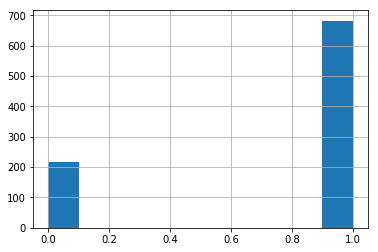

In [56]:
p_bin = pd.Series(predictions_bin)
p_bin.hist()

Confusion matrix, without normalization
[[ 40 104]
 [178 578]]


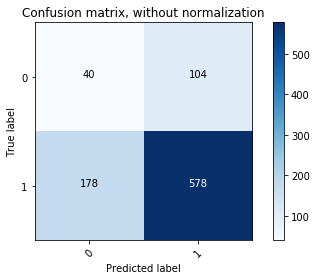

In [57]:
from sklearn.metrics import confusion_matrix
cnf_matrix= confusion_matrix(valid_y_bin, predictions_bin)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [59]:
#pred_mask = res_unet.Predict(valid_x)                             
predictions_mask = np.round(pred_mask)

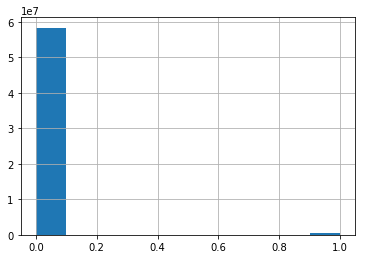

In [30]:
p_mask = pd.Series(predictions_mask.ravel())
p_mask.hist()

Confusion matrix, without normalization
[[58100690   543439]
 [  335231     3040]]


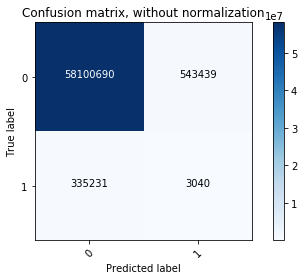

In [36]:
from sklearn.metrics import confusion_matrix
cnf_matrix= confusion_matrix(valid_y.ravel(), np.round(predictions_mask.ravel()))
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [99]:
i=0
for pred_mas, pred_bin, y_true in  zip (np.max(np.round(predictions_mask),axis = (1,2)),predictions_bin, np.max(valid_y,axis = (1,2))):
        if pred_bin == 1 and  pred_mas[0] == 0:
            print(pred_mas,pred_bin,y_true)
            i+=1
print (i)
    

[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [0]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [0]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [1]
[0.] 1.0 [0]

In [54]:
## Для отладки на рабочем компе сохраняем 
import pickle
#
#with open('pred_y_bin.txt', 'wb') as f:
#    pickle.dump(pred_y_bin, f)
#with open('pred_mask.txt', 'wb') as f:
#    pickle.dump(pred_mask, f)

######################### LOAD################
with open('pred_y_bin.txt', 'rb') as f:
    pred_y_bin = pickle.load(f)

with open('pred_mask.txt', 'rb') as f:
    pred_mask = pickle.load(f)

# Визуализируем предсказания

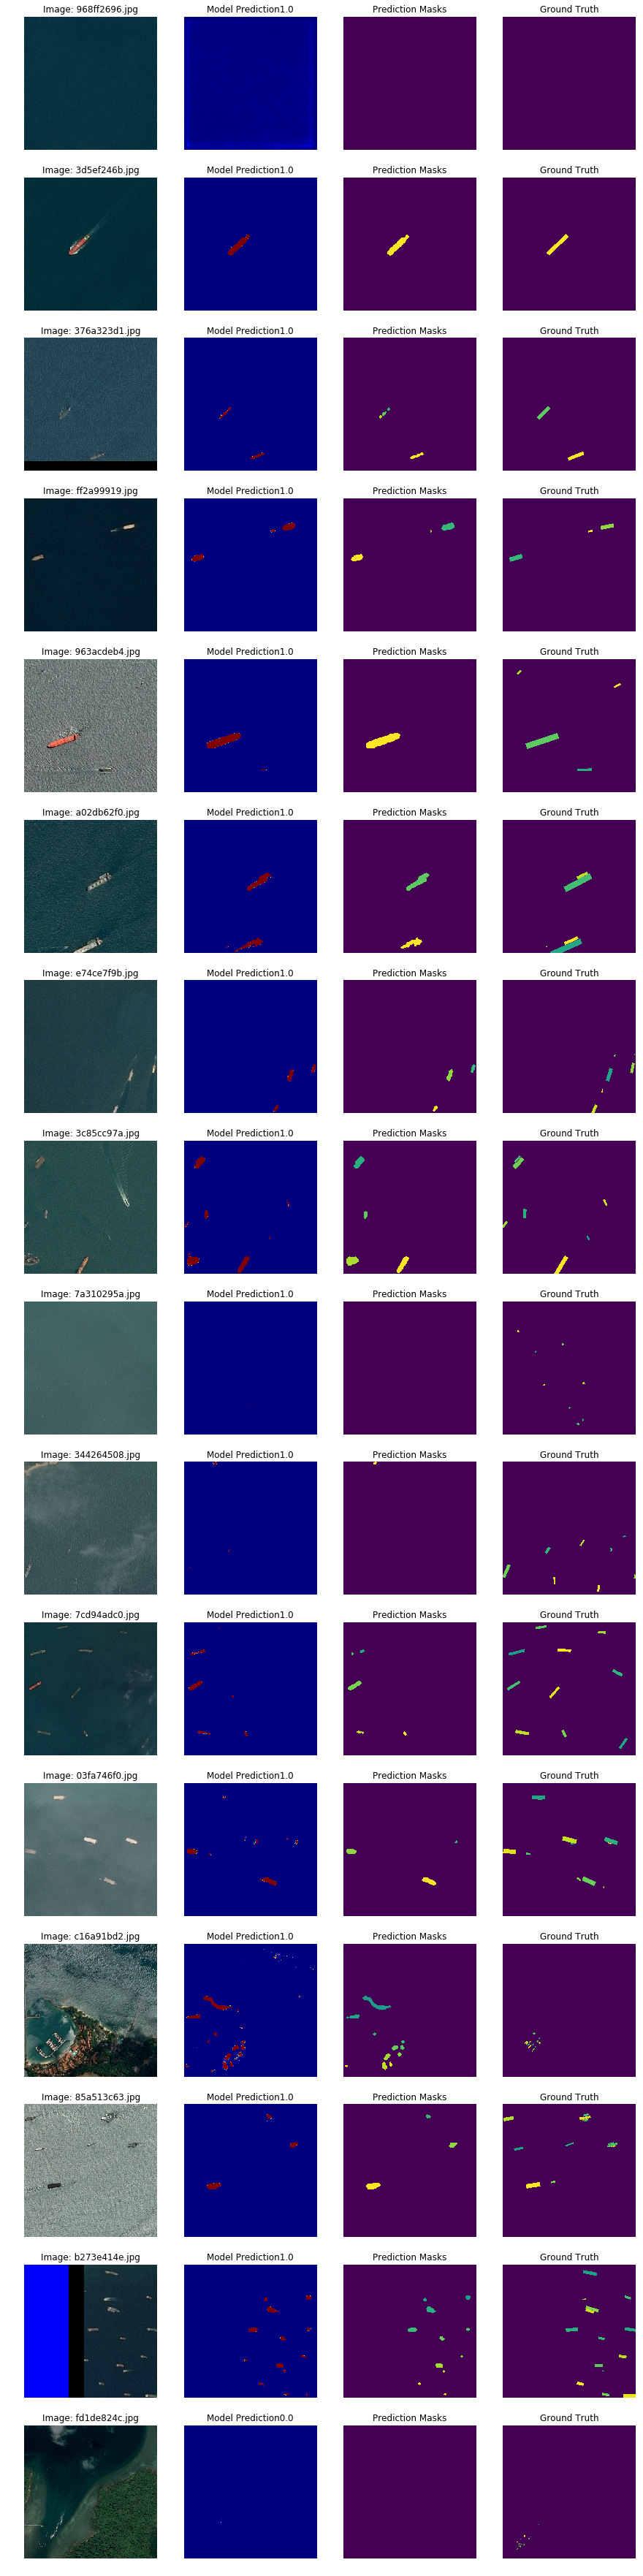

In [65]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, img))
    if IMG_SCALING is not None: # Ужимаем изображение в n раз
        c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = res_unet.Predict(c_img)[0]
    bin_seg = np.round(res.Predict(c_img)[0])[0]
    return cur_seg, c_img[0],bin_seg

def smooth(cur_seg):
    return binary_opening(cur_seg>0.4, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img,bin_seg = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img,first_bin = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction'+str(first_bin))
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]),sca=3)
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'],sca=1)
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')

# Сабмит

#### СМотрим сколько у нас изображений получилось в тесте

In [61]:
test_paths = np.array(os.listdir(test_image_dir))
print(len(test_paths), 'test images found')

15606 test images found


### делаем интерполяцию, так как модель тренировалась на изображениях 256x256

In [28]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(res_unet.model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model.h5')

## Смотрим, что получилось на предсказаниях

In [79]:
c_path = os.path.join(test_image_dir, '00002bd58.jpg')
c_img = imread(c_path)

681b3af6a.jpg
3ce74f9b3.jpg
83eae1cd2.jpg
65114eb54.jpg
3d3f43029.jpg
fe9ac1d59.jpg
9ed2b6058.jpg
a43731c17.jpg
67e5ed48e.jpg
c83c9a39b.jpg
8ad458c1d.jpg
83178d800.jpg
37f8cfb46.jpg
21e9a72fb.jpg
1c1506c14.jpg
a3f7d742f.jpg
90a32ce19.jpg
90f2b5397.jpg
c8e82879e.jpg
44b7dd30a.jpg


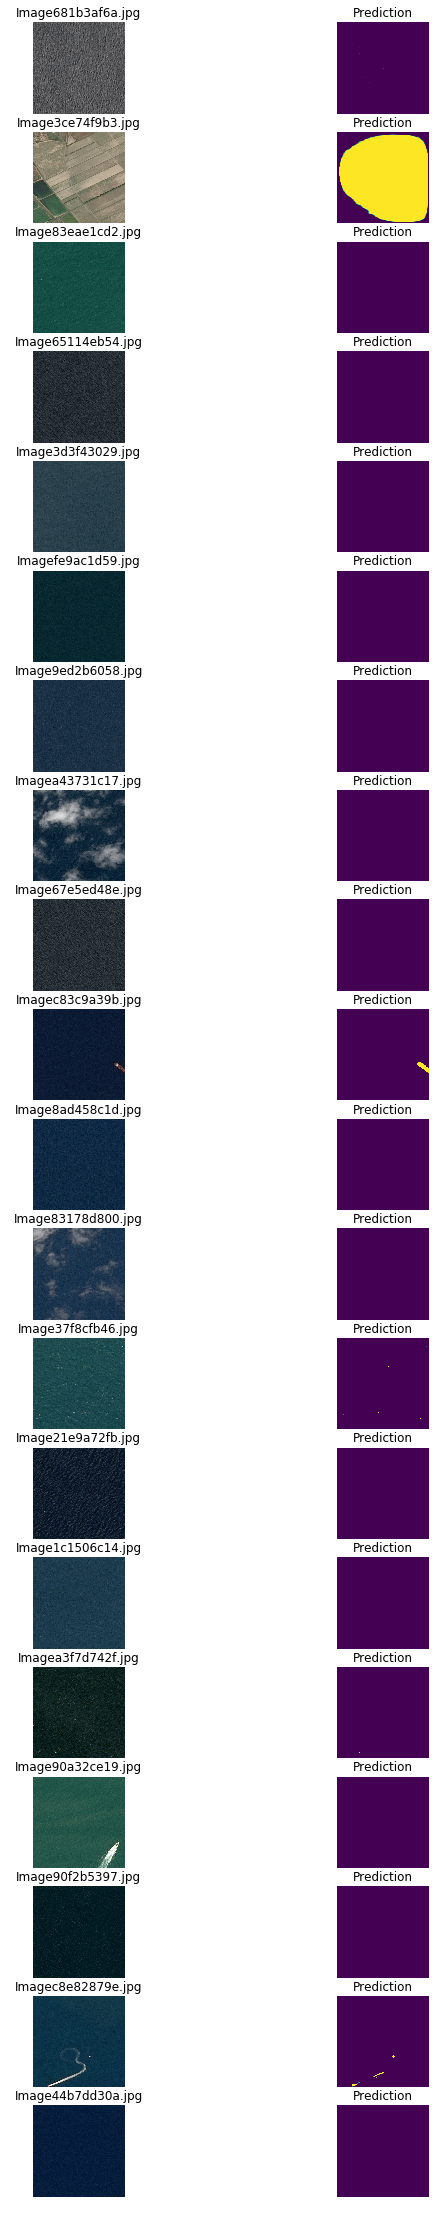

In [50]:
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image'+str(c_img_name))
    print(c_img_name)
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

## Создаем массив предсказаний

In [33]:
from tqdm import tqdm_notebook
out_pred_rows = []
for c_img_name in tqdm_notebook(test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    cur_seg = binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1))
    cur_rles = multi_rle_encode(cur_seg)
    if len(cur_rles)>0:
        for c_rle in cur_rles:
            out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': c_rle}]
    else:
        out_pred_rows += [{'ImageId': c_img_name, 'EncodedPixels': None}]


In [ ]:
with open('out_pred_rows.txt', 'wb') as f:
    
    pickle.dump(out_pred_rows, f)

## Переводим массив в pandas df, убираем нули

In [130]:
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(3)


ImageId                                      EncodedPixels
21180  823efe701.jpg  391959 2 392726 4 393493 6 394261 10 395029 11...
14243  f36802b80.jpg                                               None
7351   b1b89cf12.jpg  46665 5 47432 7 48199 9 48967 9 49736 8 50505 ...

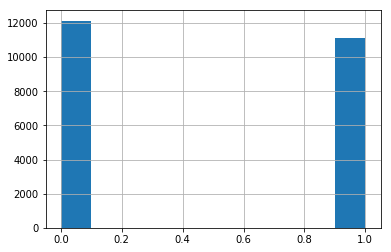

In [46]:
submission_df['counts'] = submission_df['EncodedPixels'].apply(lambda x: 1 if isinstance(x, str)  else 0)
submission_df['counts'].hist()